In [1]:
import multiprocessing
import multiprocessing as mp

def get_num_cores():
    return multiprocessing.cpu_count()

if __name__ == '__main__':
    num_cores = get_num_cores()
    print("Number of CPU cores available:", num_cores)

from tqdm import tqdm

import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pickle
import time
import warnings
import multiprocessing as mp
import numpy as np
import statsmodels.formula.api as smf
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm

import scipy.io
from scipy.io import loadmat
from scipy.interpolate import interp1d

import multiprocessing as mp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.stats.multitest import multipletests

Number of CPU cores available: 16


In [ ]:
#for the huge (>10 gb) MATLAB v7.3 file
with h5py.File('/home/ubuntu/data/full_only_before_sacc_sacclock_unfold_opticat.mat', 'r') as file:
    data = file['data'][:]

data = np.array(data)
data = data[:, :400, :]  # Slicing to take first 400 timepoints for sacc lock (before the saccade)
n_channels, n_timepoints, n_trials = data.shape
print(data.shape)  

#i want to have electrodes x timepoints x trials:
data = np.transpose(data, (2, 1, 0))
print(data.shape)  

In [4]:
# second structure - tab
tab = pd.read_csv('/home/ubuntu/data/tab_199.csv')
tab = tab.drop('Dir', axis=1)
# Categorical conversion
tab['ID'] = tab['ID'].astype('category')
tab['Age'] = tab['Age'].astype('category')
tab['Condition'] = tab['Condition'].astype('category')
print(tab.shape)  
print(tab.head())

(35475, 3)
  Condition   ID Age
0       pro  AA0   1
1       pro  AA0   1
2       pro  AA0   1
3       pro  AA0   1
4       pro  AA0   1


Downsampling! : (4x, 500 Hz -> 125 Hz)

In [ ]:
original_timepoints = np.arange(400)  
new_timepoints = np.linspace(0, 399, 100)  # New timepoints, evenly spaced

data_downsampled = np.empty((data.shape[0], 100, data.shape[2]))

# Interpolating for each elec and each tr
for i in range(data.shape[0]):  # over electrodes
    for j in range(data.shape[2]):  #trials
        f = interp1d(original_timepoints, data[i, :, j], kind='linear') #check with Nicolas
        data_downsampled[i, :, j] = f(new_timepoints)

print(data_downsampled.shape)

In [ ]:
data = data_downsampled

We dont need to run the code above, just load the downsampled data:...

In [1]:
path = '/home/ubuntu/data/downsampled_sacclocked.pkl'

In [ ]:

#def save_downsampled(data, filename='downsampled_sacclocked.pkl'):
#    with open(filename, 'wb') as f:
#        pickle.dump(data, f)

#save_downsampled(data, filename=path)

In [5]:
def load_downsampled(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

data = load_downsampled(path)
print(data.shape)  

(105, 100, 35475)


In [6]:
#for running on a smaller subset:
data = data[:,60:100,:] #for the downsampled version these 40 timepoints are corresponding to the 320 ms before the saccade
data.shape

(105, 40, 35475)

... and the second , corresponding tab structure:


In [7]:

# second structure - tab
tab = pd.read_csv('/home/ubuntu/data/tab_199.csv')
tab = tab.drop('Dir', axis=1)
# Categorical conversion
tab['ID'] = tab['ID'].astype('category')
tab['Age'] = tab['Age'].astype('category')
tab['Condition'] = tab['Condition'].astype('category')
print(tab.shape)  
print(tab.head())

(35475, 3)
  Condition   ID Age
0       pro  AA0   1
1       pro  AA0   1
2       pro  AA0   1
3       pro  AA0   1
4       pro  AA0   1


In [8]:
tab['ID'] = tab['ID'].astype('category')
tab['Age'] = tab['Age'].astype('category')
tab['Condition'] = tab['Condition'].astype('category')
n_channels, n_timepoints, n_trials = data.shape

In [9]:
# second structure - tab
tab = pd.read_csv('/home/ubuntu/data/tab_199.csv')
tab = tab.drop('Dir', axis=1)
# Categorical conversion
tab['ID'] = tab['ID'].astype('category')
tab['Age'] = tab['Age'].astype('category')
tab['Condition'] = tab['Condition'].astype('category')
print(tab.shape)  
print(tab.head())

(35475, 3)
  Condition   ID Age
0       pro  AA0   1
1       pro  AA0   1
2       pro  AA0   1
3       pro  AA0   1
4       pro  AA0   1


In [ ]:
def fit_model(channel, timepoint, data, tab):
    start_time = time.time()
    print(f"Starting model for channel {channel}, timepoint {timepoint}")
    eeg_data = data[channel, timepoint, :]
    current_tab = tab.copy()
    current_tab['EEG'] = eeg_data
    formula = 'EEG ~ 1 + Condition * Age'
    current_tab['ID'] = current_tab['ID'].cat.codes
    model = smf.mixedlm(formula, current_tab, groups=current_tab['ID'])
    try:
        result = model.fit()
        elapsed_time = time.time() - start_time
        print(f"Finished model for channel {channel}, timepoint {timepoint} in {elapsed_time:.2f} seconds")
        return (channel, timepoint, result, elapsed_time)
    except np.linalg.LinAlgError:
        elapsed_time = time.time() - start_time
        print(f"Model failed to converge for channel {channel}, timepoint {timepoint}")
        return (channel, timepoint, "Model failed to converge", elapsed_time)

if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    results = {}
    n_channels = 105
    n_timepoints = 40

    num_cores = mp.cpu_count()
    print(f"Number of available cores: {num_cores}")
    pool = mp.Pool(processes=num_cores) 
    jobs = []

    for channel in range(n_channels):
        for timepoint in range(n_timepoints):
            print(f"Submitting job for channel {channel}, timepoint {timepoint}")
            job = pool.apply_async(fit_model, args=(channel, timepoint, data, tab))
            jobs.append(job)

    pool.close()
    pool.join()

    total_elapsed_time = 0
    for job in jobs:
        channel, timepoint, result, elapsed_time = job.get()
        results[(channel, timepoint)] = result
        total_elapsed_time += elapsed_time

    print(f"Total time taken for all models: {total_elapsed_time} seconds")


In [12]:
def save_results(results, filename='model_results_40t.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(results, f)
        
path = '/home/ubuntu/data/model_results_40t.pkl'
save_results(results, filename=path)

---
---
---

## with the pre-calculated results we can start here!

In [2]:
def load_results(filename='model_results_40t.pkl'):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [3]:
filename = '/home/ubuntu/data/model_results_40t.pkl'
results = load_results(filename)

In [4]:
print(results[(6, 8)].summary())  # Example  model's summary

               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    EEG         
No. Observations:     35475      Method:                REML        
No. Groups:           199        Scale:                 186.9711    
Min. group size:      33         Log-Likelihood:        -143217.8836
Max. group size:      238        Converged:             Yes         
Mean group size:      178.3                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 -0.033    0.183 -0.180 0.857 -0.392  0.326
Condition[T.pro]           0.117    0.189  0.617 0.537 -0.254  0.488
Age[T.1]                  -0.507    0.285 -1.778 0.075 -1.066  0.052
Condition[T.pro]:Age[T.1]  0.134    0.296  0.453 0.650 -0.446  0.715
Group Var                  1.751    0.020         

In [5]:
#variance

def extract_group_var(results):
    group_vars = {}
    for key, result in results.items():
        try:
            summary_str = result.summary().as_text()
            for line in summary_str.split('\n'):
                if 'Group Var' in line:
                    group_var_value = float(line.split()[2])  
                    group_vars[key] = group_var_value
                    break
        except Exception as e:
            print(f"Failed to extract for {key}: {str(e)}")
    return group_vars

def plot_group_vars(group_vars, n_channels, n_timepoints):
    group_var_matrix = np.zeros((n_channels, n_timepoints))

    for (channel, timepoint), group_var in group_vars.items():
        group_var_matrix[channel, timepoint] = group_var

    cmap = sns.color_palette("YlGn", as_cmap=True)

    bounds = [0, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, np.max(group_var_matrix)]
    norm = BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

    # Plot the heatmap
    plt.figure(figsize=(24, 12))
    sns.heatmap(group_var_matrix, cmap=cmap, norm=norm, cbar=True, square=True, 
                cbar_kws={'label': 'Group Variance'}, linewidths=.5, linecolor='gray')
    plt.xlabel('Timepoints', fontsize=14)
    plt.ylabel('Channels', fontsize=14)
    plt.title('Heatmap of Group Variance Across Channels and Timepoints', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()



In [6]:
#convergence

def extract_convergence(results):
    convergence_status = {}
    for key, result in results.items():
        try:
            convergence_status[key] = 'Yes' if result.converged else 'No'
        except AttributeError:
            convergence_status[key] = 'Unknown'
        except Exception as e:
            print(f"Failed to extract for {key}: {str(e)}")
    return convergence_status



def plot_convergence(convergence_status, n_channels, n_timepoints):
    convergence_matrix = np.full((n_channels, n_timepoints), 'Unknown', dtype=object)

    for (channel, timepoint), status in convergence_status.items():
        convergence_matrix[channel, timepoint] = status

    status_to_num = {'Yes': 1, 'No': 0, 'Unknown': -1}
    convergence_matrix_num = np.vectorize(status_to_num.get)(convergence_matrix)

    colors = ["red", "gray", "blue"]
    cmap = ListedColormap(colors)

    plt.figure(figsize=(24, 12))
    sns.heatmap(convergence_matrix_num, cmap=cmap, cbar=True, square=True, 
                cbar_kws={'ticks': [0, 1], 'label': 'Convergence Status'},
                linewidths=.5, linecolor='gray')
    plt.xlabel('Timepoints', fontsize=14)
    plt.ylabel('Channels', fontsize=14)
    plt.title('Heatmap of Convergence Status Across Channels and Timepoints', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()



Plots:

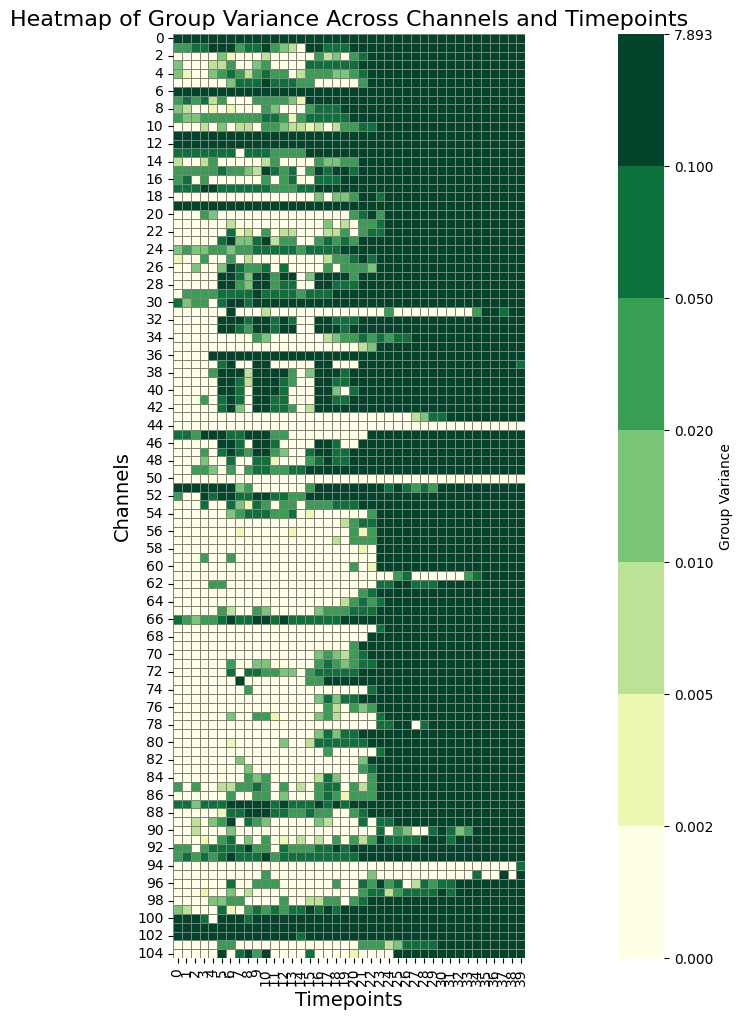

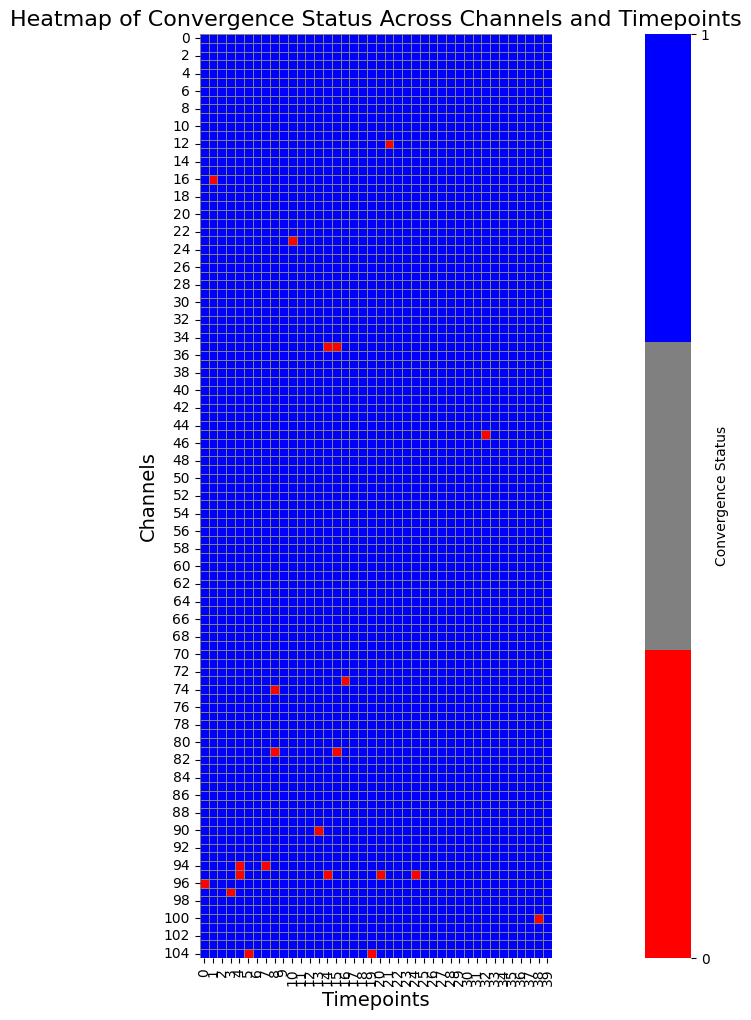

In [7]:
n_channels = 105
n_timepoints = 40

group_vars = extract_group_var(results)
convergence_status = extract_convergence(results)
plot_group_vars(group_vars, n_channels, n_timepoints)
plot_convergence(convergence_status, n_channels, n_timepoints)

STATISTICS:

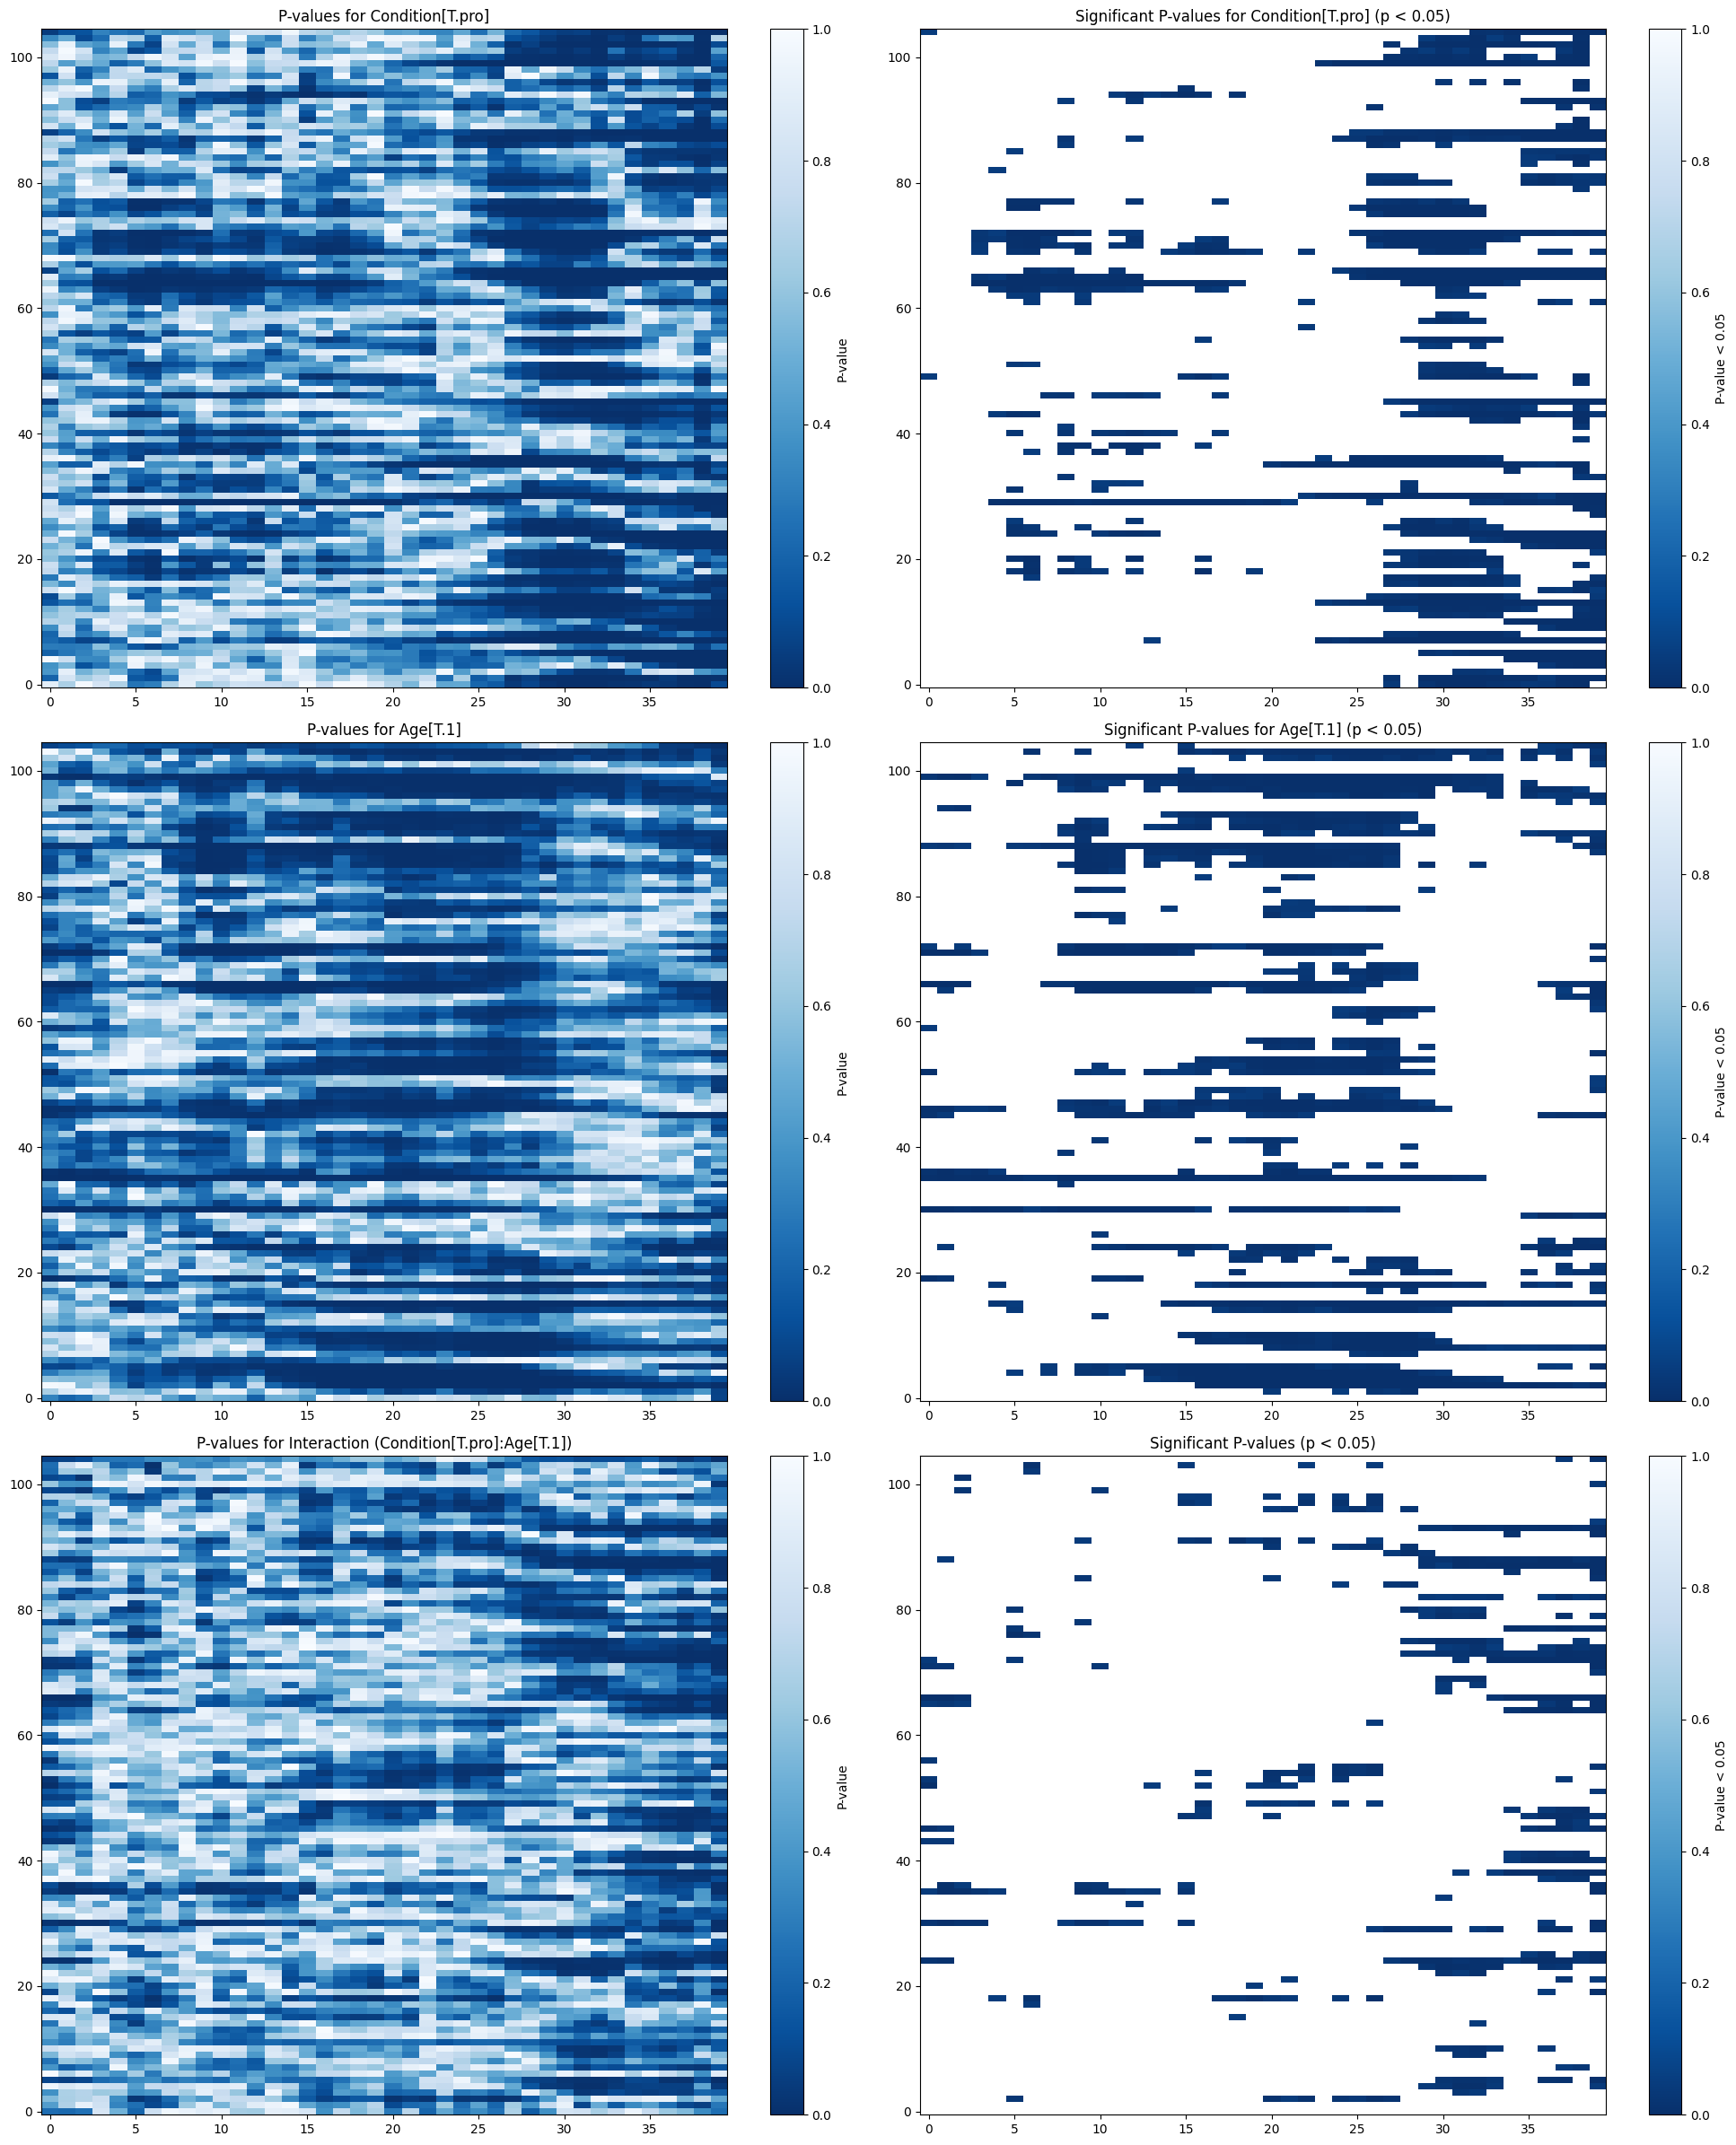

In [8]:
def plot_complex_pvalues(results):
    plt.figure(figsize=(20, 24))  #  3 rows and 2 columns of plots

    pvalues_cond = extract_pvalues(results, 'Condition[T.pro]')
    pvalues_age = extract_pvalues(results, 'Age[T.1]')
    pvalues_interaction = extract_pvalues(results, 'Condition[T.pro]:Age[T.1]')

    # Condition[T.pro]
    ax1 = plt.subplot(3, 2, 1)
    cax1 = ax1.imshow(pvalues_cond, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax1, ax=ax1, label='P-value')
    ax1.set_title('P-values for Condition[T.pro]')

    ax2 = plt.subplot(3, 2, 2)
    significant_cond = np.where(pvalues_cond < 0.05, pvalues_cond, np.nan)
    cax2 = ax2.imshow(significant_cond, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax2, ax=ax2, label='P-value < 0.05')
    ax2.set_title('Significant P-values for Condition[T.pro] (p < 0.05)')

    # Age[T.1]
    ax3 = plt.subplot(3, 2, 3)
    cax3 = ax3.imshow(pvalues_age, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax3, ax=ax3, label='P-value')
    ax3.set_title('P-values for Age[T.1]')

    ax4 = plt.subplot(3, 2, 4)
    significant_age = np.where(pvalues_age < 0.05, pvalues_age, np.nan)
    cax4 = ax4.imshow(significant_age, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax4, ax=ax4, label='P-value < 0.05')
    ax4.set_title('Significant P-values for Age[T.1] (p < 0.05)')

    # Interaction
    ax5 = plt.subplot(3, 2, 5)
    cax5 = ax5.imshow(pvalues_interaction, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax5, ax=ax5, label='P-value')
    ax5.set_title('P-values for Interaction (Condition[T.pro]:Age[T.1])')

    ax6 = plt.subplot(3, 2, 6)
    significant_interaction = np.where(pvalues_interaction < 0.05, pvalues_interaction, np.nan)
    cax6 = ax6.imshow(significant_interaction, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax6, ax=ax6, label='P-value < 0.05')
    ax6.set_title('Significant P-values (p < 0.05)')

    plt.tight_layout()  
    plt.show()

def extract_pvalues(results, term):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    pvalues = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            p_value = result.pvalues[term]
            pvalues[channel, timepoint] = p_value
        except (KeyError, AttributeError):
            print(f"Missing p-value for {term} (Channel {channel}, Timepoint {timepoint})")

    return pvalues

def load_results(filename):
    import pickle
    with open(filename, 'rb') as f:
        return pickle.load(f)


plot_complex_pvalues(results)

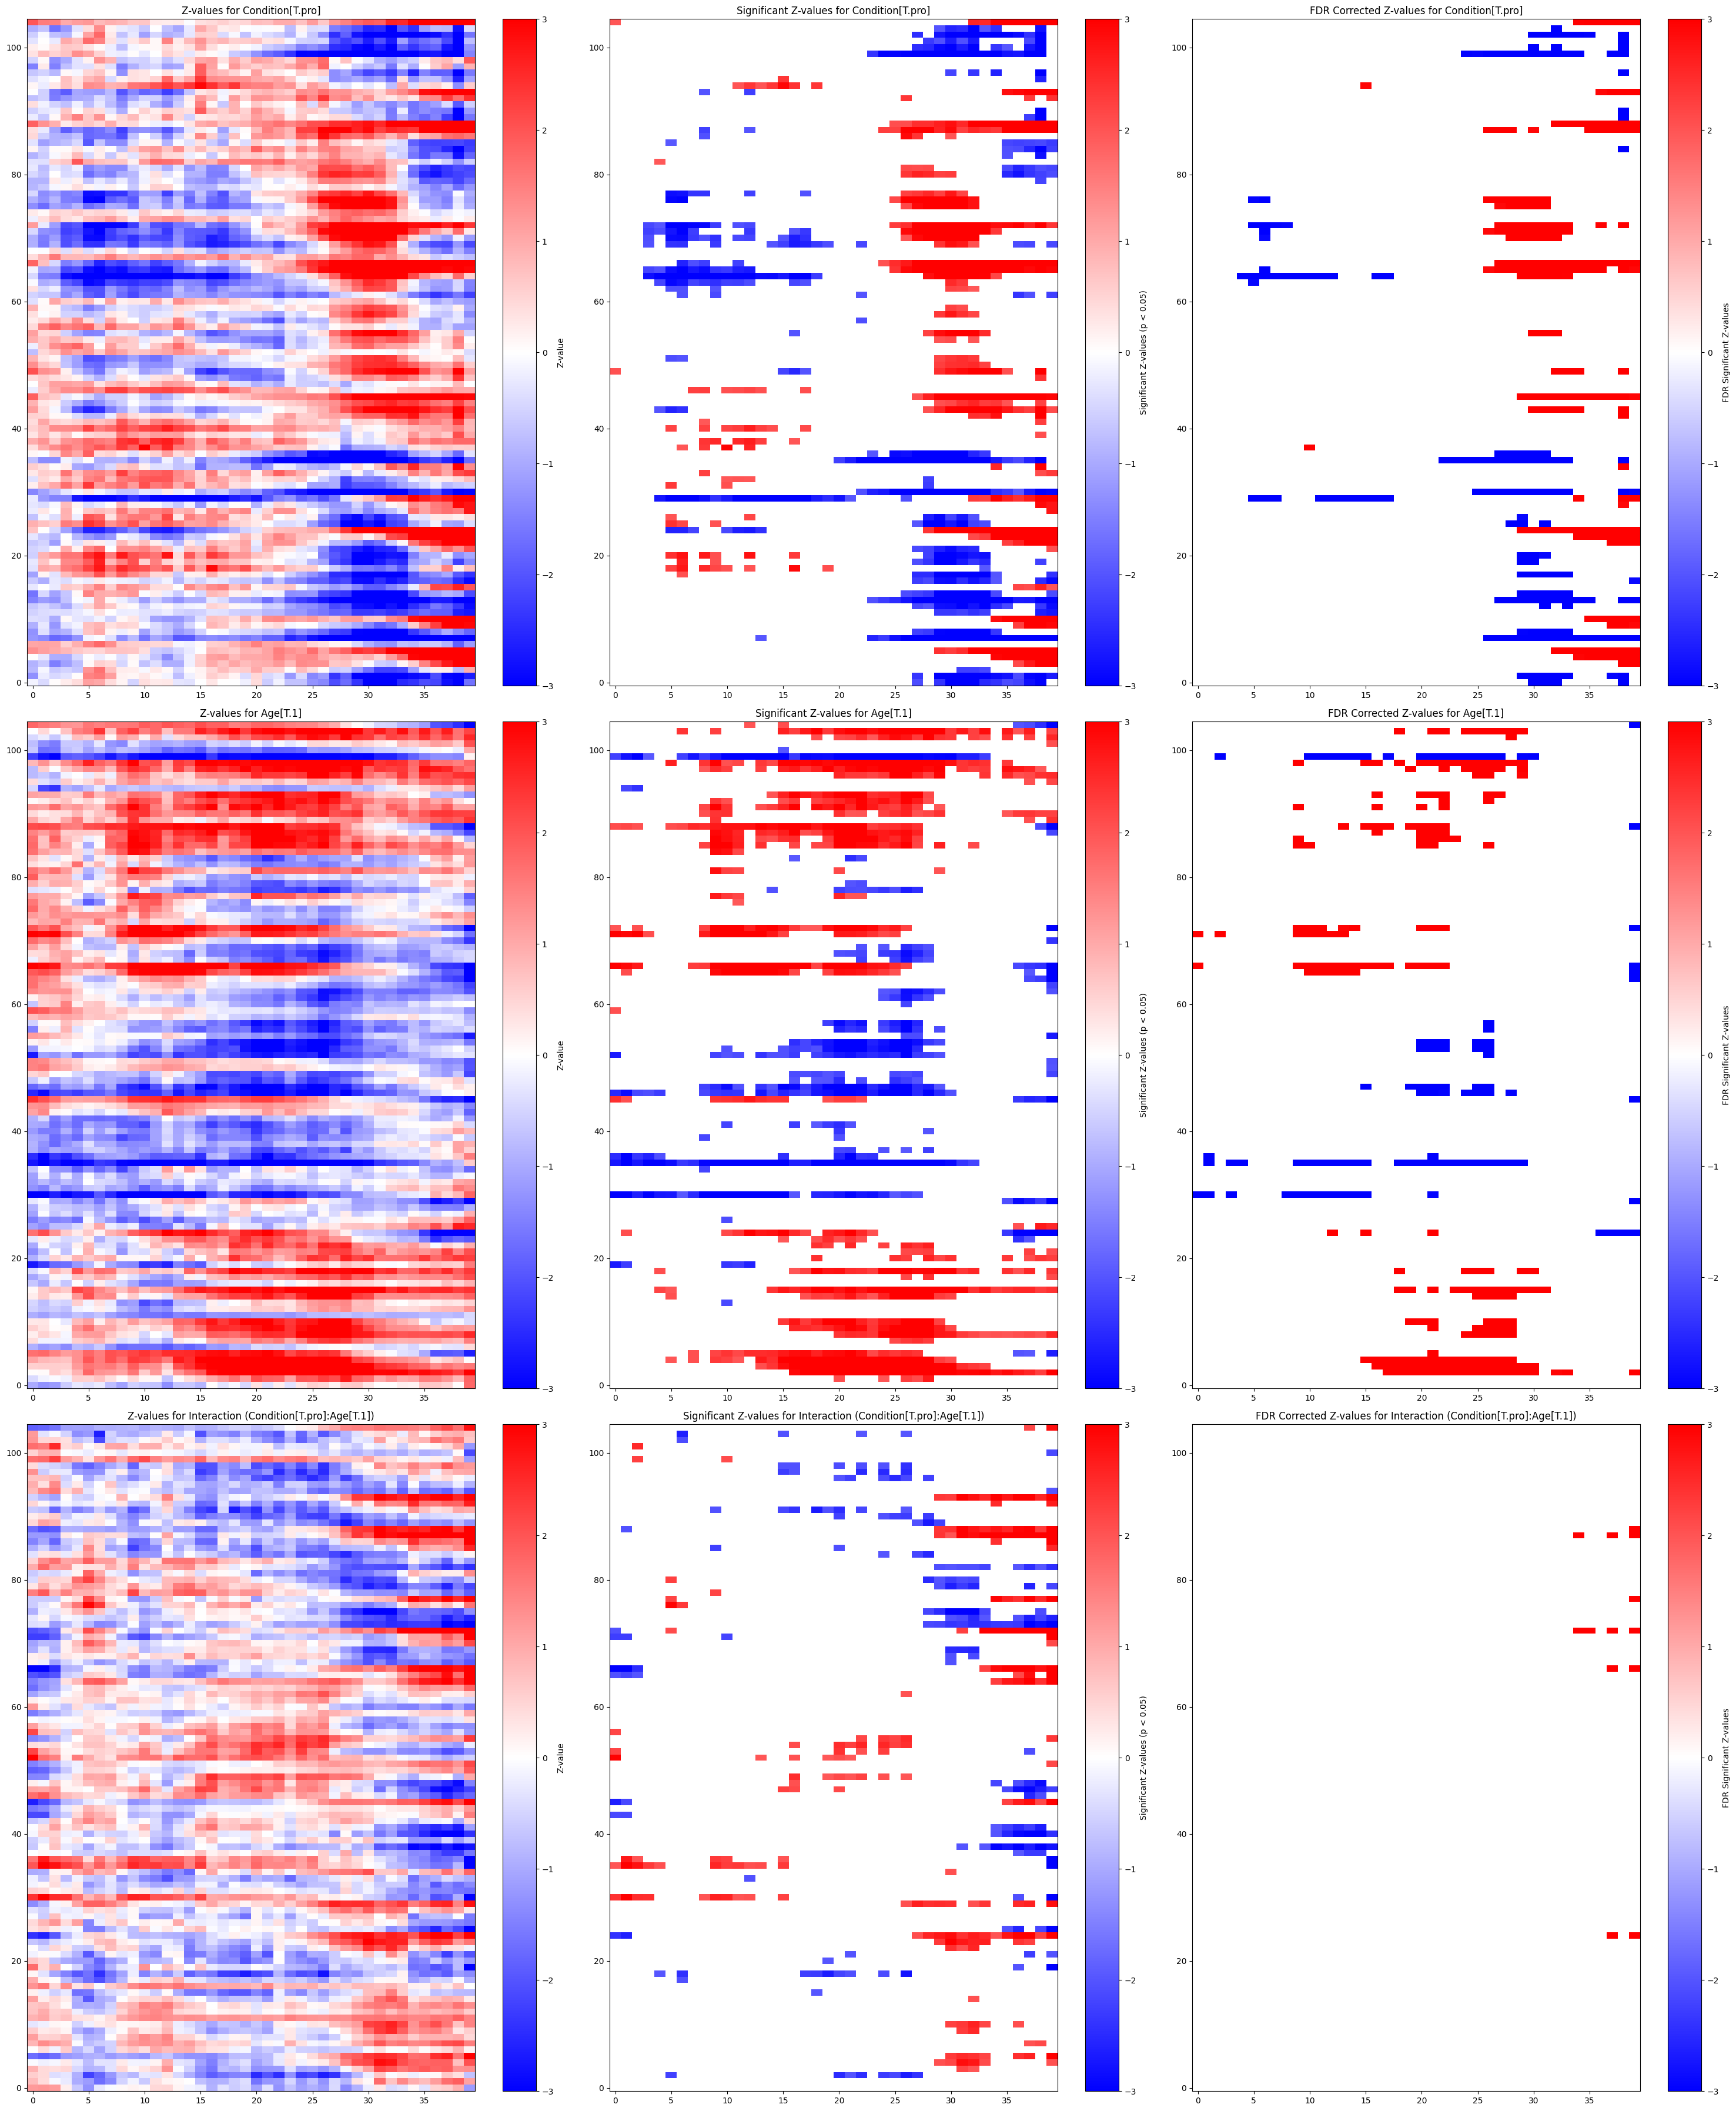

In [10]:

import statsmodels.stats.multitest as smm

def plot_complex_zvalues_fdr(results):
    plt.figure(figsize=(30, 36))  

    # Extracting z-values and p-values
    zvalues_cond = extract_zvalues(results, 'Condition[T.pro]')
    zvalues_age = extract_zvalues(results, 'Age[T.1]')
    zvalues_interaction = extract_zvalues(results, 'Condition[T.pro]:Age[T.1]')
    pvalues_cond = extract_pvalues(results, 'Condition[T.pro]')
    pvalues_age = extract_pvalues(results, 'Age[T.1]')
    pvalues_interaction = extract_pvalues(results, 'Condition[T.pro]:Age[T.1]')

    # Applying FDR correction
    fdr_cond = smm.multipletests(pvalues_cond.flatten(), method='fdr_bh')[1].reshape(pvalues_cond.shape)
    fdr_age = smm.multipletests(pvalues_age.flatten(), method='fdr_bh')[1].reshape(pvalues_age.shape)
    fdr_interaction = smm.multipletests(pvalues_interaction.flatten(), method='fdr_bh')[1].reshape(pvalues_interaction.shape)

    # Create subplots for each variable and its significant values
    plot_zvalues(zvalues_cond, pvalues_cond, fdr_cond, 1, 'Condition[T.pro]')
    plot_zvalues(zvalues_age, pvalues_age, fdr_age, 4, 'Age[T.1]')
    plot_zvalues(zvalues_interaction, pvalues_interaction, fdr_interaction, 7, 'Interaction (Condition[T.pro]:Age[T.1])')

    plt.tight_layout()
    plt.show()

def plot_zvalues(zvalues, pvalues, fdr_values, start_idx, title):
    axes = [plt.subplot(3, 3, i) for i in range(start_idx, start_idx + 3)]
    # Original Z-values
    cax = axes[0].imshow(zvalues, aspect='auto', interpolation='none', origin='lower', cmap='bwr', vmin=-3, vmax=3)
    plt.colorbar(cax, ax=axes[0], label='Z-value')
    axes[0].set_title(f'Z-values for {title}')

    # Significant Z-values (original p-values)
    significant_z = np.where(pvalues < 0.05, zvalues, np.nan)
    cax_sig = axes[1].imshow(significant_z, aspect='auto', interpolation='none', origin='lower', cmap='bwr', vmin=-3, vmax=3)
    plt.colorbar(cax_sig, ax=axes[1], label='Significant Z-values (p < 0.05)')
    axes[1].set_title(f'Significant Z-values for {title}')

    # FDR corrected significant Z-values
    fdr_sig_z = np.where(fdr_values < 0.05, zvalues, np.nan)
    cax_fdr = axes[2].imshow(fdr_sig_z, aspect='auto', interpolation='none', origin='lower', cmap='bwr', vmin=-3, vmax=3)
    plt.colorbar(cax_fdr, ax=axes[2], label='FDR Significant Z-values')
    axes[2].set_title(f'FDR Corrected Z-values for {title}')

def extract_zvalues(results, term):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    zvalues = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            z_value = result.tvalues[term] 
            zvalues[channel, timepoint] = z_value
        except (KeyError, AttributeError):
            print(f"Missing z-value for {term} (Channel {channel}, Timepoint {timepoint})")

    return zvalues

def extract_pvalues(results, term):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    pvalues = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            p_value = result.pvalues[term]
            pvalues[channel, timepoint] = p_value
        except (KeyError, AttributeError):
            print(f"Missing p-value for {term} (Channel {channel}, Timepoint {timepoint})")

    return pvalues

def load_results(filename):
    import pickle
    with open(filename, 'rb') as f:
        return pickle.load(f)


plot_complex_zvalues_fdr(results)

"softer", more liberal version of FDR:

In [11]:
#modified version of the FDR:

def plot_complex_zvalues_fdr(results):
    plt.figure(figsize=(30, 36))  

    # Extracting z-values and p-values
    zvalues_cond = extract_zvalues(results, 'Condition[T.pro]')
    zvalues_age = extract_zvalues(results, 'Age[T.1]')
    zvalues_interaction = extract_zvalues(results, 'Condition[T.pro]:Age[T.1]')
    pvalues_cond = extract_pvalues(results, 'Condition[T.pro]')
    pvalues_age = extract_pvalues(results, 'Age[T.1]')
    pvalues_interaction = extract_pvalues(results, 'Condition[T.pro]:Age[T.1]')

    # Applying FDR correction only across timepoints
    fdr_cond = np.array([smm.multipletests(pvalues_cond[channel,:].flatten(), method='fdr_bh')[1]
                         for channel in range(pvalues_cond.shape[0])]).reshape(pvalues_cond.shape)
    fdr_age = np.array([smm.multipletests(pvalues_age[channel,:].flatten(), method='fdr_bh')[1]
                        for channel in range(pvalues_age.shape[0])]).reshape(pvalues_age.shape)
    fdr_interaction = np.array([smm.multipletests(pvalues_interaction[channel,:].flatten(), method='fdr_bh')[1]
                                for channel in range(pvalues_interaction.shape[0])]).reshape(pvalues_interaction.shape)

    #  subplots for each variable and its significant values
    plot_zvalues(zvalues_cond, pvalues_cond, fdr_cond, 1, 'Condition[T.pro]')
    plot_zvalues(zvalues_age, pvalues_age, fdr_age, 4, 'Age[T.1]')
    plot_zvalues(zvalues_interaction, pvalues_interaction, fdr_interaction, 7, 'Interaction (Condition[T.pro]:Age[T.1])')

    plt.tight_layout()
    plt.show()

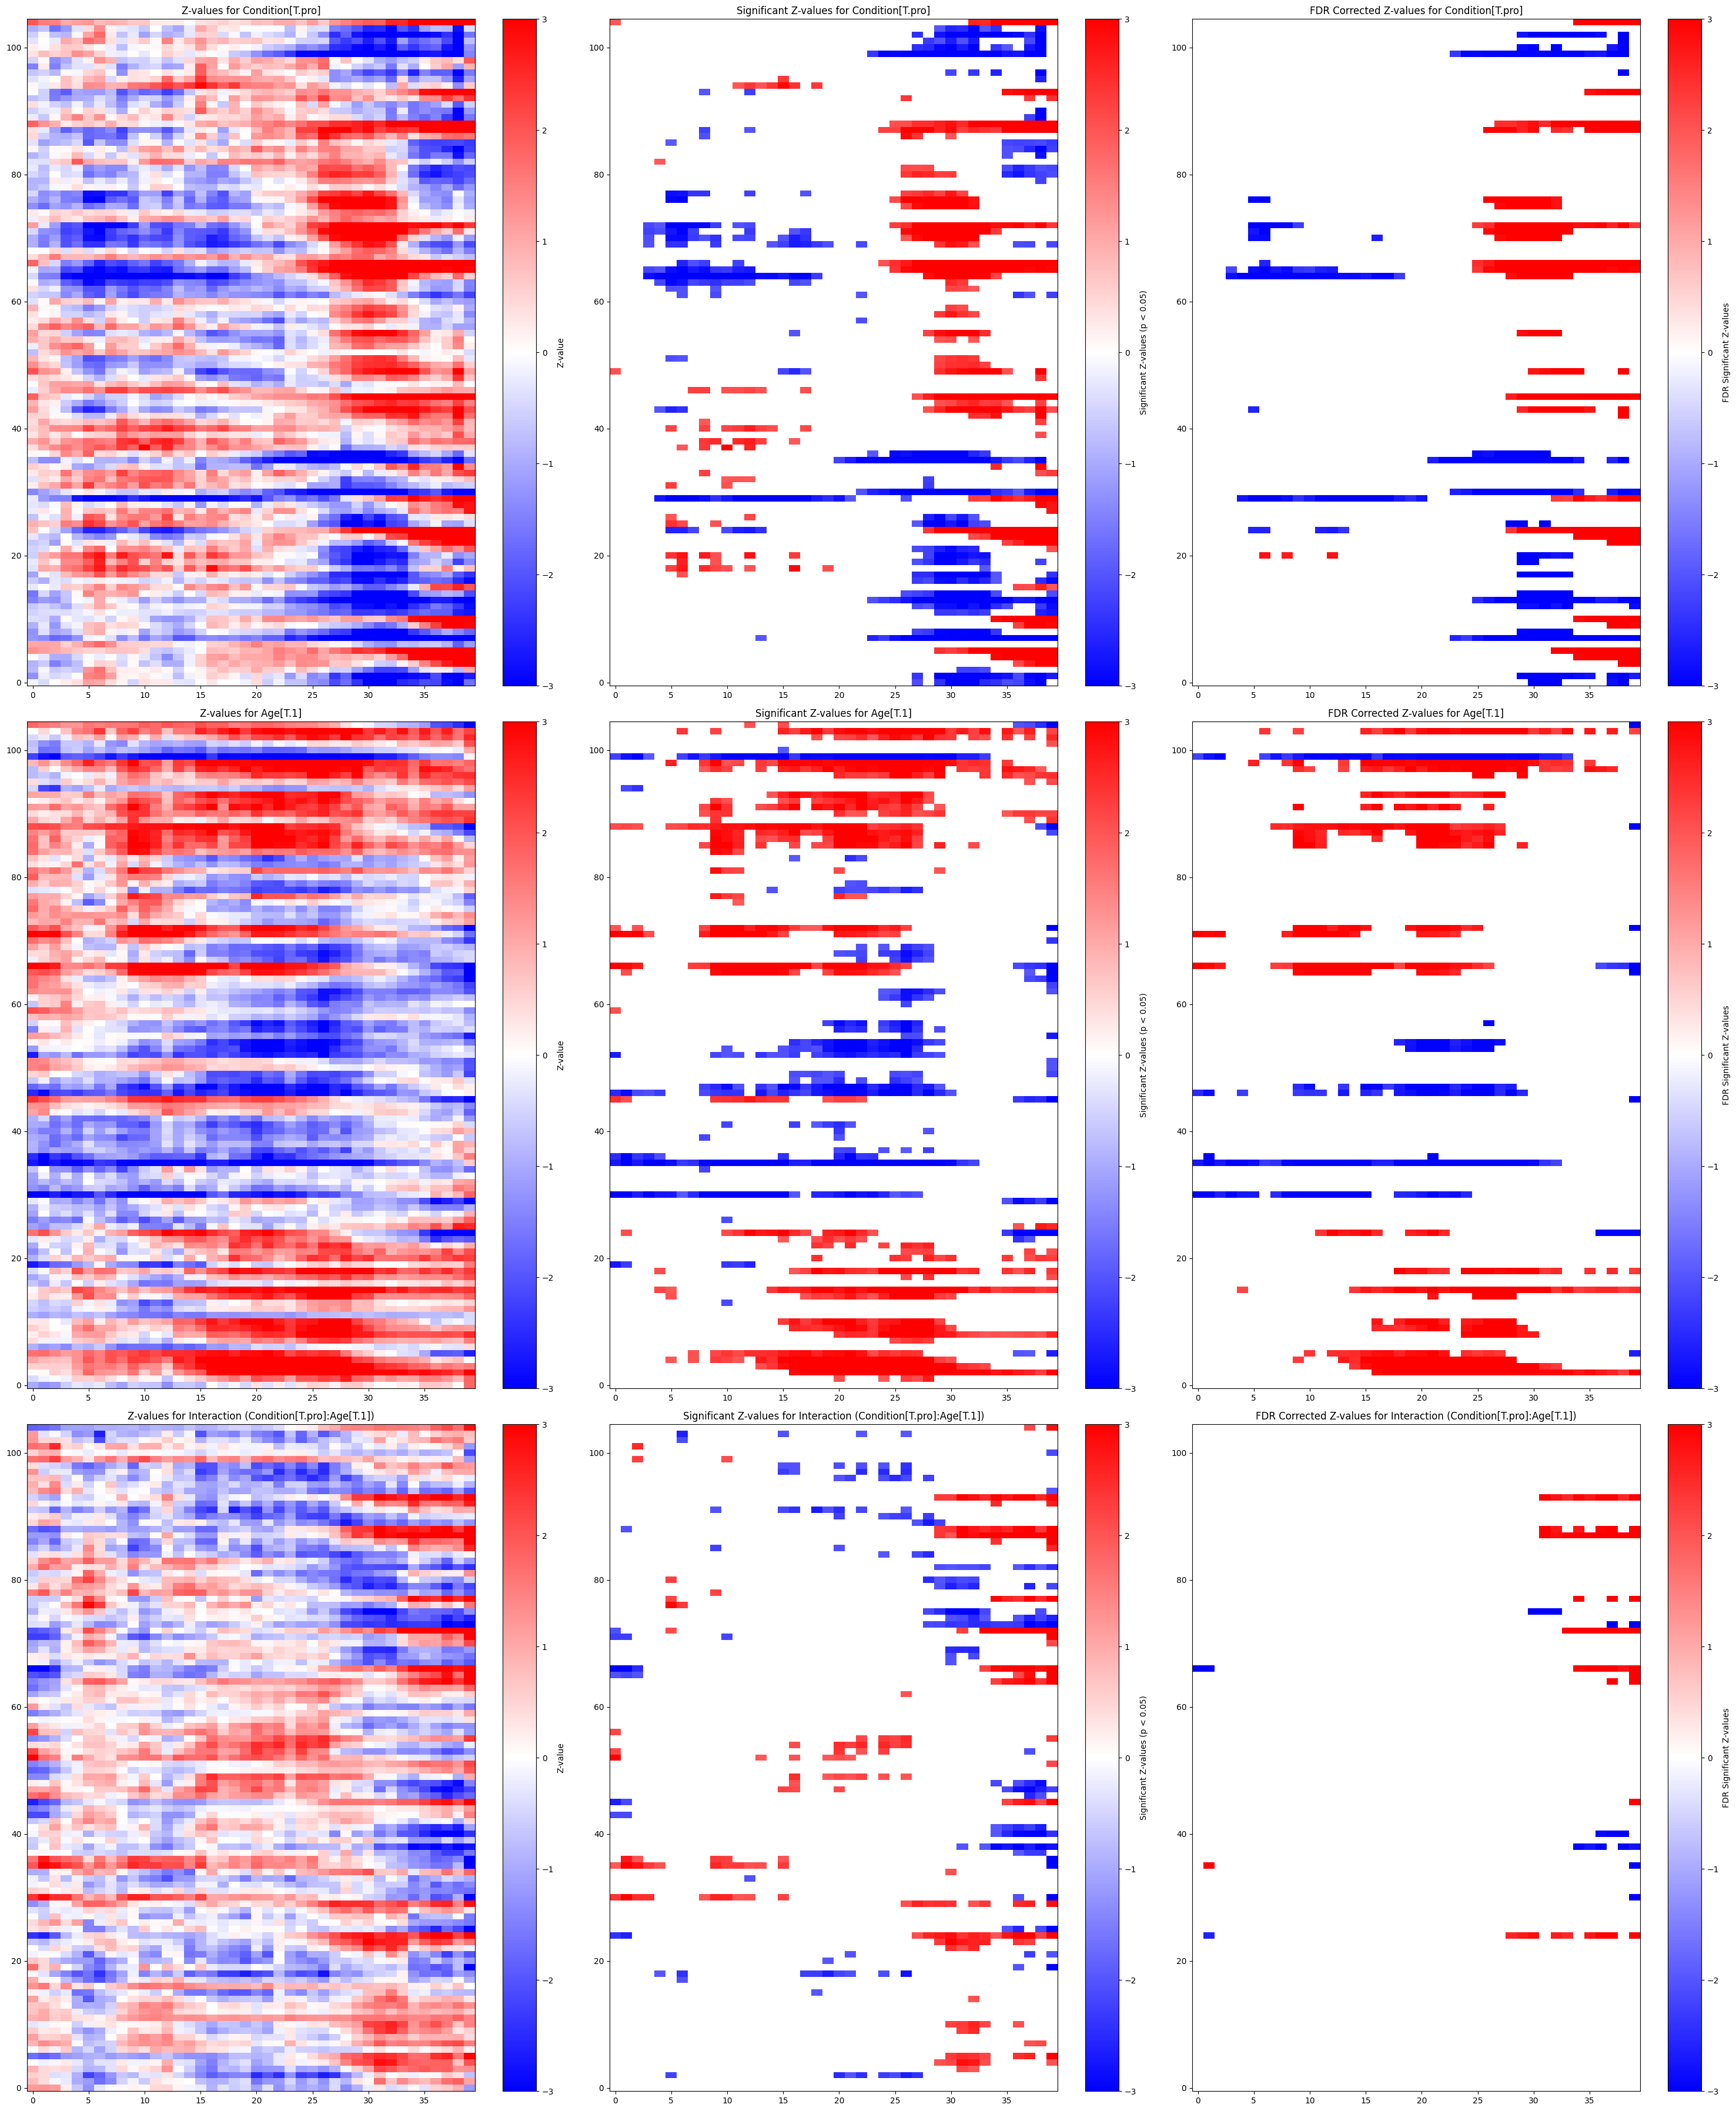

In [12]:
plot_complex_zvalues_fdr(results)

Coefficients 

In [20]:
def plot_complex_coefficients_with_significance(results):
    plt.figure(figsize=(20, 24))  # 3 rows and 2 columns of plots

    coefs_cond = extract_coefficients(results, 'Condition[T.pro]')
    coefs_age = extract_coefficients(results, 'Age[T.1]')
    coefs_interaction = extract_coefficients(results, 'Condition[T.pro]:Age[T.1]')
    
    pvalues_cond = extract_pvalues(results, 'Condition[T.pro]')
    pvalues_age = extract_pvalues(results, 'Age[T.1]')
    pvalues_interaction = extract_pvalues(results, 'Condition[T.pro]:Age[T.1]')

    # Function to filter significant coefficients based on p-values
    def filter_significant_coefs(coefs, pvalues, threshold=0.05):
        significant_coefs = np.where(pvalues < threshold, coefs, np.nan)
        return significant_coefs

    significant_coefs_cond = filter_significant_coefs(coefs_cond, pvalues_cond)
    significant_coefs_age = filter_significant_coefs(coefs_age, pvalues_age)
    significant_coefs_interaction = filter_significant_coefs(coefs_interaction, pvalues_interaction)

    # Condition[T.pro]
    ax1 = plt.subplot(3, 2, 1)
    cax1 = ax1.imshow(coefs_cond, aspect='auto', interpolation='none', origin='lower', cmap='coolwarm')
    plt.colorbar(cax1, ax=ax1, label='Coefficient')
    ax1.set_title('Coefficients for Condition[T.pro]')

    ax2 = plt.subplot(3, 2, 2)
    cax2 = ax2.imshow(significant_coefs_cond, aspect='auto', interpolation='none', origin='lower', cmap='coolwarm')
    plt.colorbar(cax2, ax=ax2, label='Coefficient (significant, p < 0.05)')
    ax2.set_title('Significant Coefficients for Condition[T.pro] (p < 0.05)')

    # Age[T.1]
    ax3 = plt.subplot(3, 2, 3)
    cax3 = ax3.imshow(coefs_age, aspect='auto', interpolation='none', origin='lower', cmap='coolwarm')
    plt.colorbar(cax3, ax=ax3, label='Coefficient')
    ax3.set_title('Coefficients for Age[T.1]')

    ax4 = plt.subplot(3, 2, 4)
    cax4 = ax4.imshow(significant_coefs_age, aspect='auto', interpolation='none', origin='lower', cmap='coolwarm')
    plt.colorbar(cax4, ax=ax4, label='Coefficient (significant, p < 0.05)')
    ax4.set_title('Significant Coefficients for Age[T.1] (p < 0.05)')

    # Interaction
    ax5 = plt.subplot(3, 2, 5)
    cax5 = ax5.imshow(coefs_interaction, aspect='auto', interpolation='none', origin='lower', cmap='coolwarm')
    plt.colorbar(cax5, ax=ax5, label='Coefficient')
    ax5.set_title('Coefficients for Interaction (Condition[T.pro]:Age[T.1])')

    ax6 = plt.subplot(3, 2, 6)
    cax6 = ax6.imshow(significant_coefs_interaction, aspect='auto', interpolation='none', origin='lower', cmap='coolwarm')
    plt.colorbar(cax6, ax=ax6, label='Coefficient (significant, p < 0.05)')
    ax6.set_title('Significant Coefficients for Interaction (p < 0.05)')

    plt.tight_layout()
    plt.show()

def extract_coefficients(results, term):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    coefficients = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            coef = result.params[term]
            coefficients[channel, timepoint] = coef
        except (KeyError, AttributeError):
            print(f"Missing coefficient for {term} (Channel {channel}, Timepoint {timepoint})")

    return coefficients

def extract_pvalues(results, term):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    pvalues = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            p_value = result.pvalues[term]
            pvalues[channel, timepoint] = p_value
        except (KeyError, AttributeError):
            print(f"Missing p-value for {term} (Channel {channel}, Timepoint {timepoint})")

    return pvalues


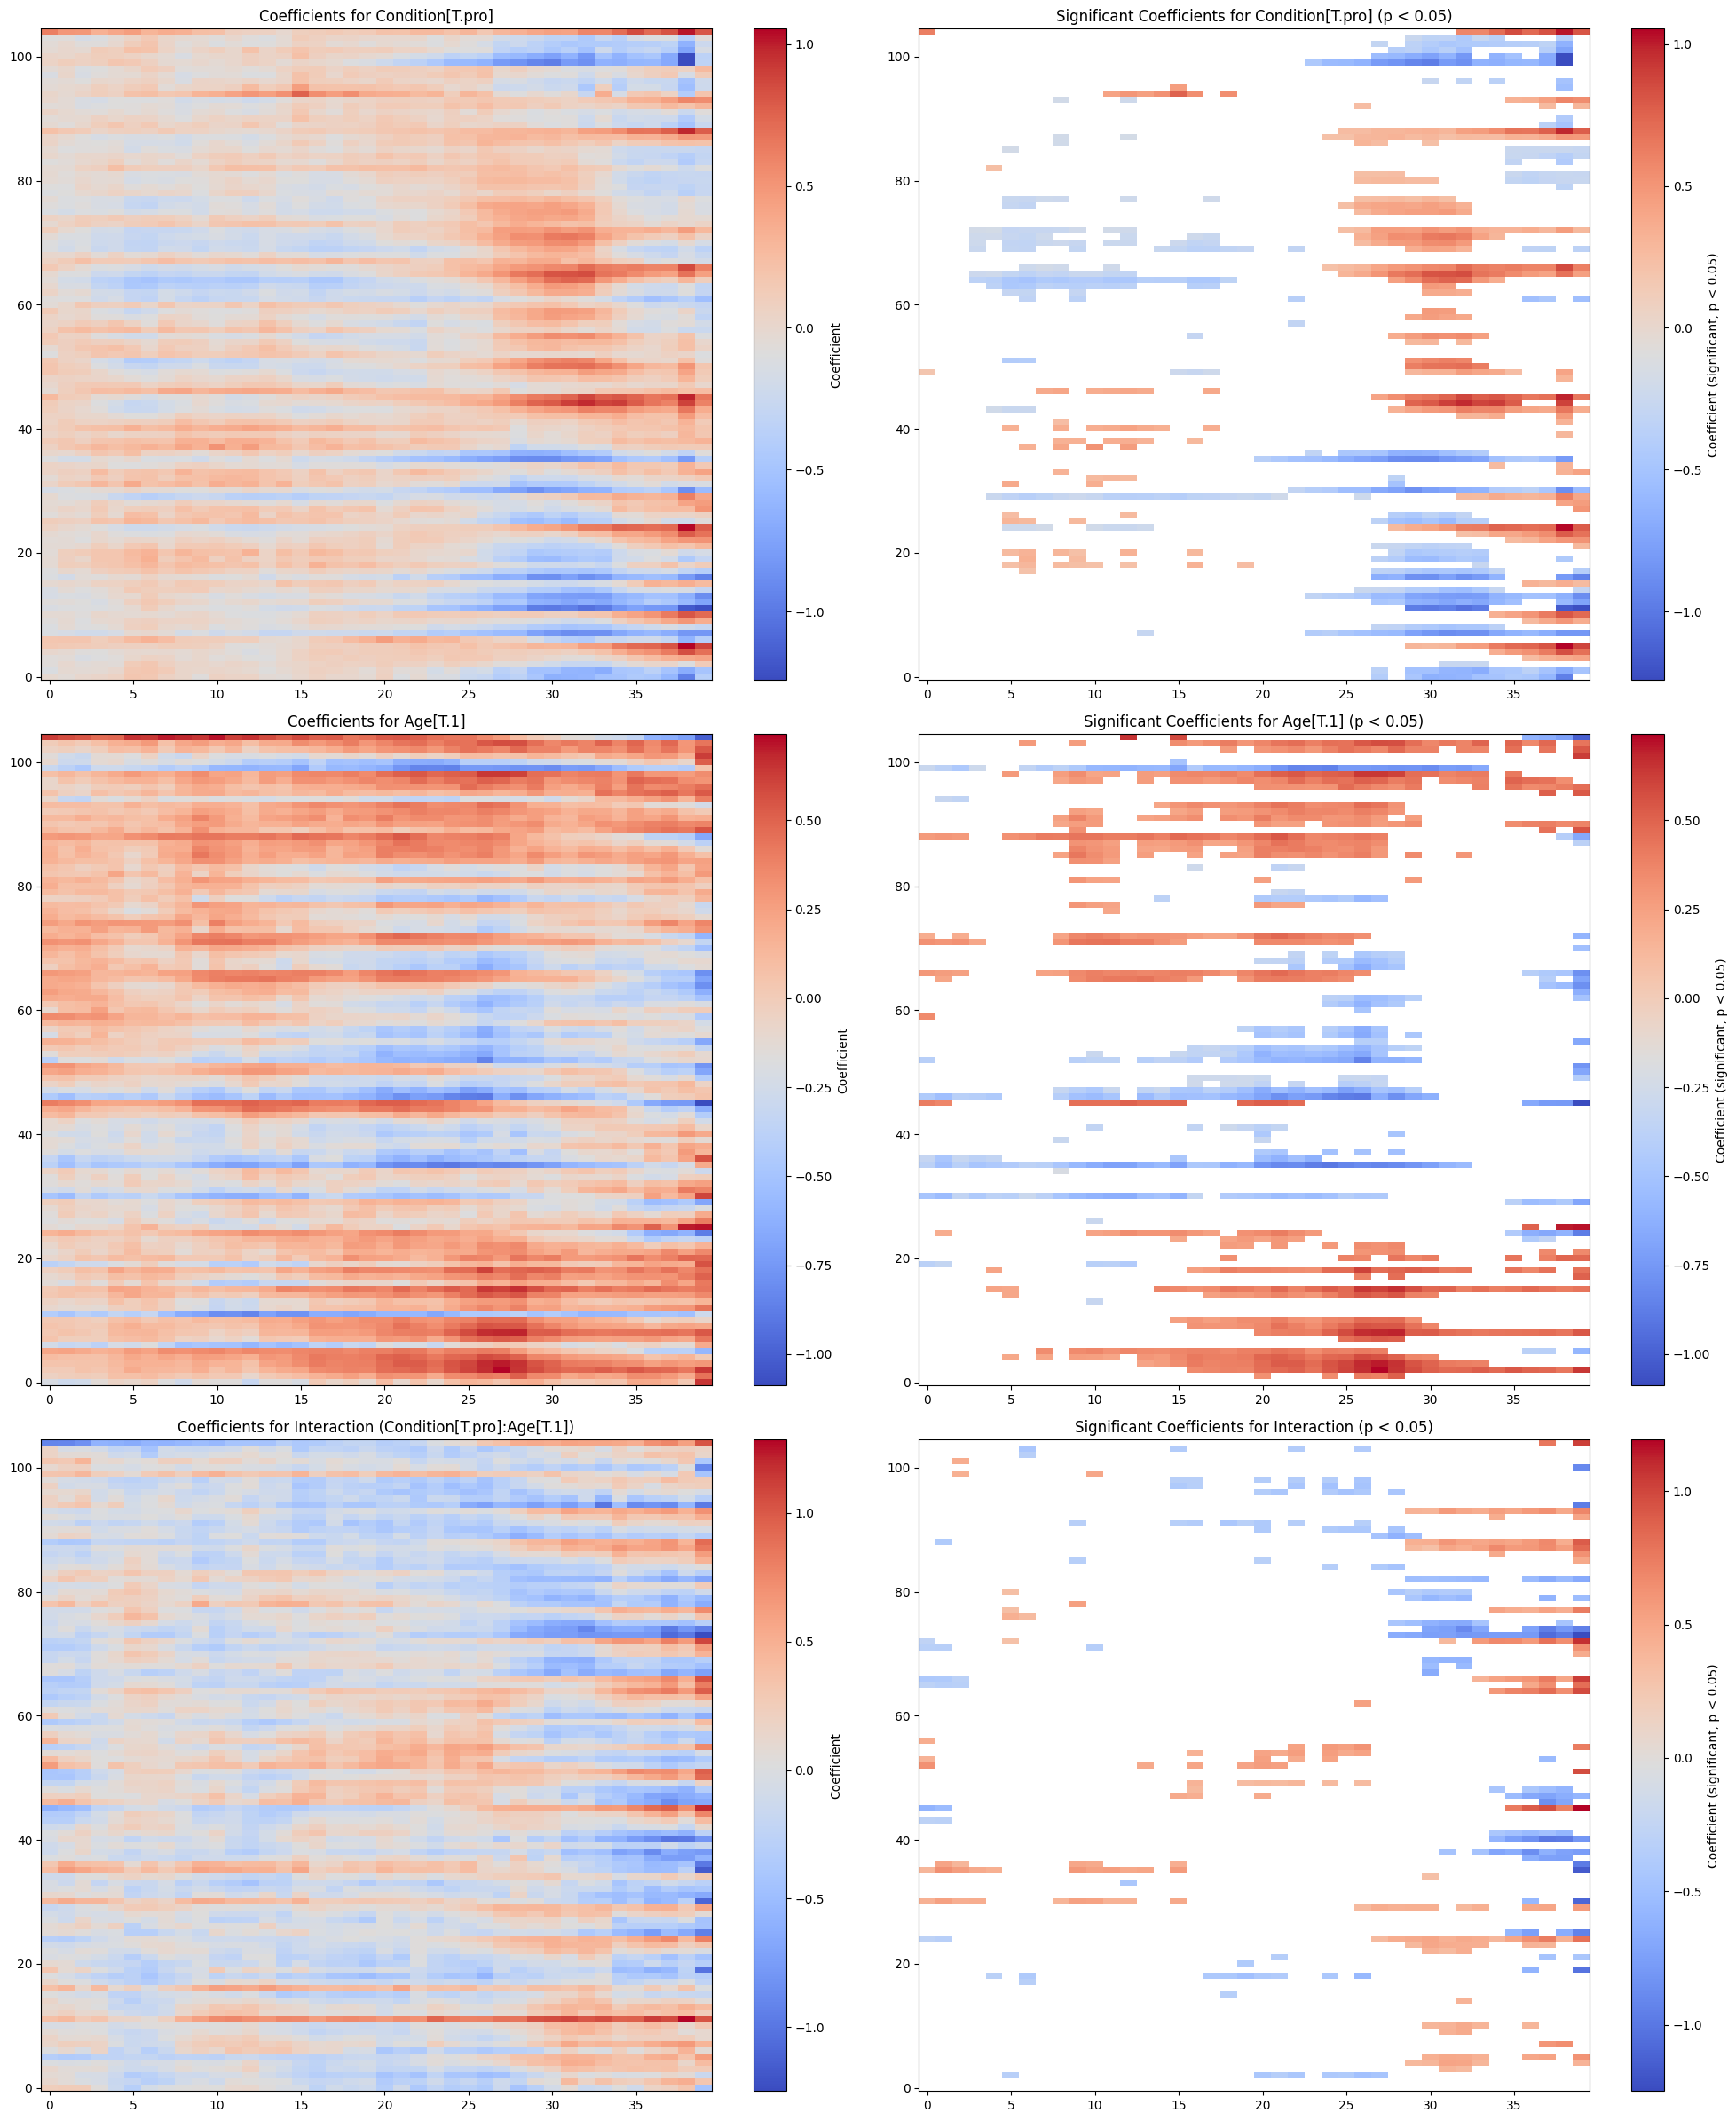

In [21]:
plot_complex_coefficients_with_significance(results)

In [26]:

def plot_complex_coefficients_with_significance(results):
    plt.figure(figsize=(20, 36))  # 3 rows and 3 columns of plots

    coefs_cond = extract_coefficients(results, 'Condition[T.pro]')
    coefs_age = extract_coefficients(results, 'Age[T.1]')
    coefs_interaction = extract_coefficients(results, 'Condition[T.pro]:Age[T.1]')
    
    pvalues_cond = extract_pvalues(results, 'Condition[T.pro]')
    pvalues_age = extract_pvalues(results, 'Age[T.1]')
    pvalues_interaction = extract_pvalues(results, 'Condition[T.pro]:Age[T.1]')

    # Function to filter significant coefficients based on p-values
    def filter_significant_coefs(coefs, pvalues, threshold=0.05):
        significant_coefs = np.where(pvalues < threshold, coefs, np.nan)
        return significant_coefs

    # Function to filter significant coefficients based on FDR-corrected p-values
    def filter_significant_coefs_with_fdr(coefs, pvalues, alpha=0.05):
        flat_pvalues = pvalues.flatten()
        _, corrected_pvalues, _, _ = multipletests(flat_pvalues, alpha=alpha, method='fdr_bh')
        corrected_pvalues = corrected_pvalues.reshape(pvalues.shape)
        significant_coefs = np.where(corrected_pvalues < alpha, coefs, np.nan)
        return significant_coefs

    significant_coefs_cond = filter_significant_coefs(coefs_cond, pvalues_cond)
    significant_coefs_age = filter_significant_coefs(coefs_age, pvalues_age)
    significant_coefs_interaction = filter_significant_coefs(coefs_interaction, pvalues_interaction)

    significant_coefs_cond_fdr = filter_significant_coefs_with_fdr(coefs_cond, pvalues_cond)
    significant_coefs_age_fdr = filter_significant_coefs_with_fdr(coefs_age, pvalues_age)
    significant_coefs_interaction_fdr = filter_significant_coefs_with_fdr(coefs_interaction, pvalues_interaction)

    # Plotting coefficients for Age[T.1]
    ax1 = plt.subplot(3, 3, 1)
    cax1 = ax1.imshow(coefs_age, aspect='auto', interpolation='none', origin='lower', cmap='coolwarm')
    plt.colorbar(cax1, ax=ax1, label='Coefficient')
    ax1.set_title('Coefficients for Age[T.1]')

    ax2 = plt.subplot(3, 3, 2)
    cax2 = ax2.imshow(significant_coefs_age, aspect='auto', interpolation='none', origin='lower', cmap='coolwarm')
    plt.colorbar(cax2, ax=ax2, label='Coefficient (significant, p < 0.05)')
    ax2.set_title('Significant Coefficients for Age[T.1] (p < 0.05)')

    ax3 = plt.subplot(3, 3, 3)
    cax3 = ax3.imshow(significant_coefs_age_fdr, aspect='auto', interpolation='none', origin='lower', cmap='coolwarm')
    plt.colorbar(cax3, ax=ax3, label='Coefficient (significant, FDR < 0.05)')
    ax3.set_title('Significant Coefficients for Age[T.1] (FDR < 0.05)')

    # Plotting coefficients for Condition[T.pro]
    ax4 = plt.subplot(3, 3, 4)
    cax4 = ax4.imshow(coefs_cond, aspect='auto', interpolation='none', origin='lower', cmap='coolwarm')
    plt.colorbar(cax4, ax=ax4, label='Coefficient')
    ax4.set_title('Coefficients for Condition[T.pro]')

    ax5 = plt.subplot(3, 3, 5)
    cax5 = ax5.imshow(significant_coefs_cond, aspect='auto', interpolation='none', origin='lower', cmap='coolwarm')
    plt.colorbar(cax5, ax=ax5, label='Coefficient (significant, p < 0.05)')
    ax5.set_title('Significant Coefficients for Condition[T.pro] (p < 0.05)')

    ax6 = plt.subplot(3, 3, 6)
    cax6 = ax6.imshow(significant_coefs_cond_fdr, aspect='auto', interpolation='none', origin='lower', cmap='coolwarm')
    plt.colorbar(cax6, ax=ax6, label='Coefficient (significant, FDR < 0.05)')
    ax6.set_title('Significant Coefficients for Condition[T.pro] (FDR < 0.05)')

    # Plotting coefficients for Interaction (Condition[T.pro]:Age[T.1])
    ax7 = plt.subplot(3, 3, 7)
    cax7 = ax7.imshow(coefs_interaction, aspect='auto', interpolation='none', origin='lower', cmap='coolwarm')
    plt.colorbar(cax7, ax=ax7, label='Coefficient')
    ax7.set_title('Coefficients for Interaction (Condition[T.pro]:Age[T.1])')

    ax8 = plt.subplot(3, 3, 8)
    cax8 = ax8.imshow(significant_coefs_interaction, aspect='auto', interpolation='none', origin='lower', cmap='coolwarm')
    plt.colorbar(cax8, ax=ax8, label='Coefficient (significant, p < 0.05)')
    ax8.set_title('Significant Coefficients for Interaction (p < 0.05)')

    ax9 = plt.subplot(3, 3, 9)
    cax9 = ax9.imshow(significant_coefs_interaction_fdr, aspect='auto', interpolation='none', origin='lower', cmap='coolwarm')
    plt.colorbar(cax9, ax=ax9, label='Coefficient (significant, FDR < 0.05)')
    ax9.set_title('Significant Coefficients for Interaction (FDR < 0.05)')

    plt.tight_layout()
    plt.show()

def extract_coefficients(results, term):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    coefficients = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            coef = result.params[term]
            coefficients[channel, timepoint] = coef
        except (KeyError, AttributeError):
            print(f"Missing coefficient for {term} (Channel {channel}, Timepoint {timepoint})")

    return coefficients

def extract_pvalues(results, term):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    pvalues = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            p_value = result.pvalues[term]
            pvalues[channel, timepoint] = p_value
        except (KeyError, AttributeError):
            print(f"Missing p-value for {term} (Channel {channel}, Timepoint {timepoint})")

    return pvalues


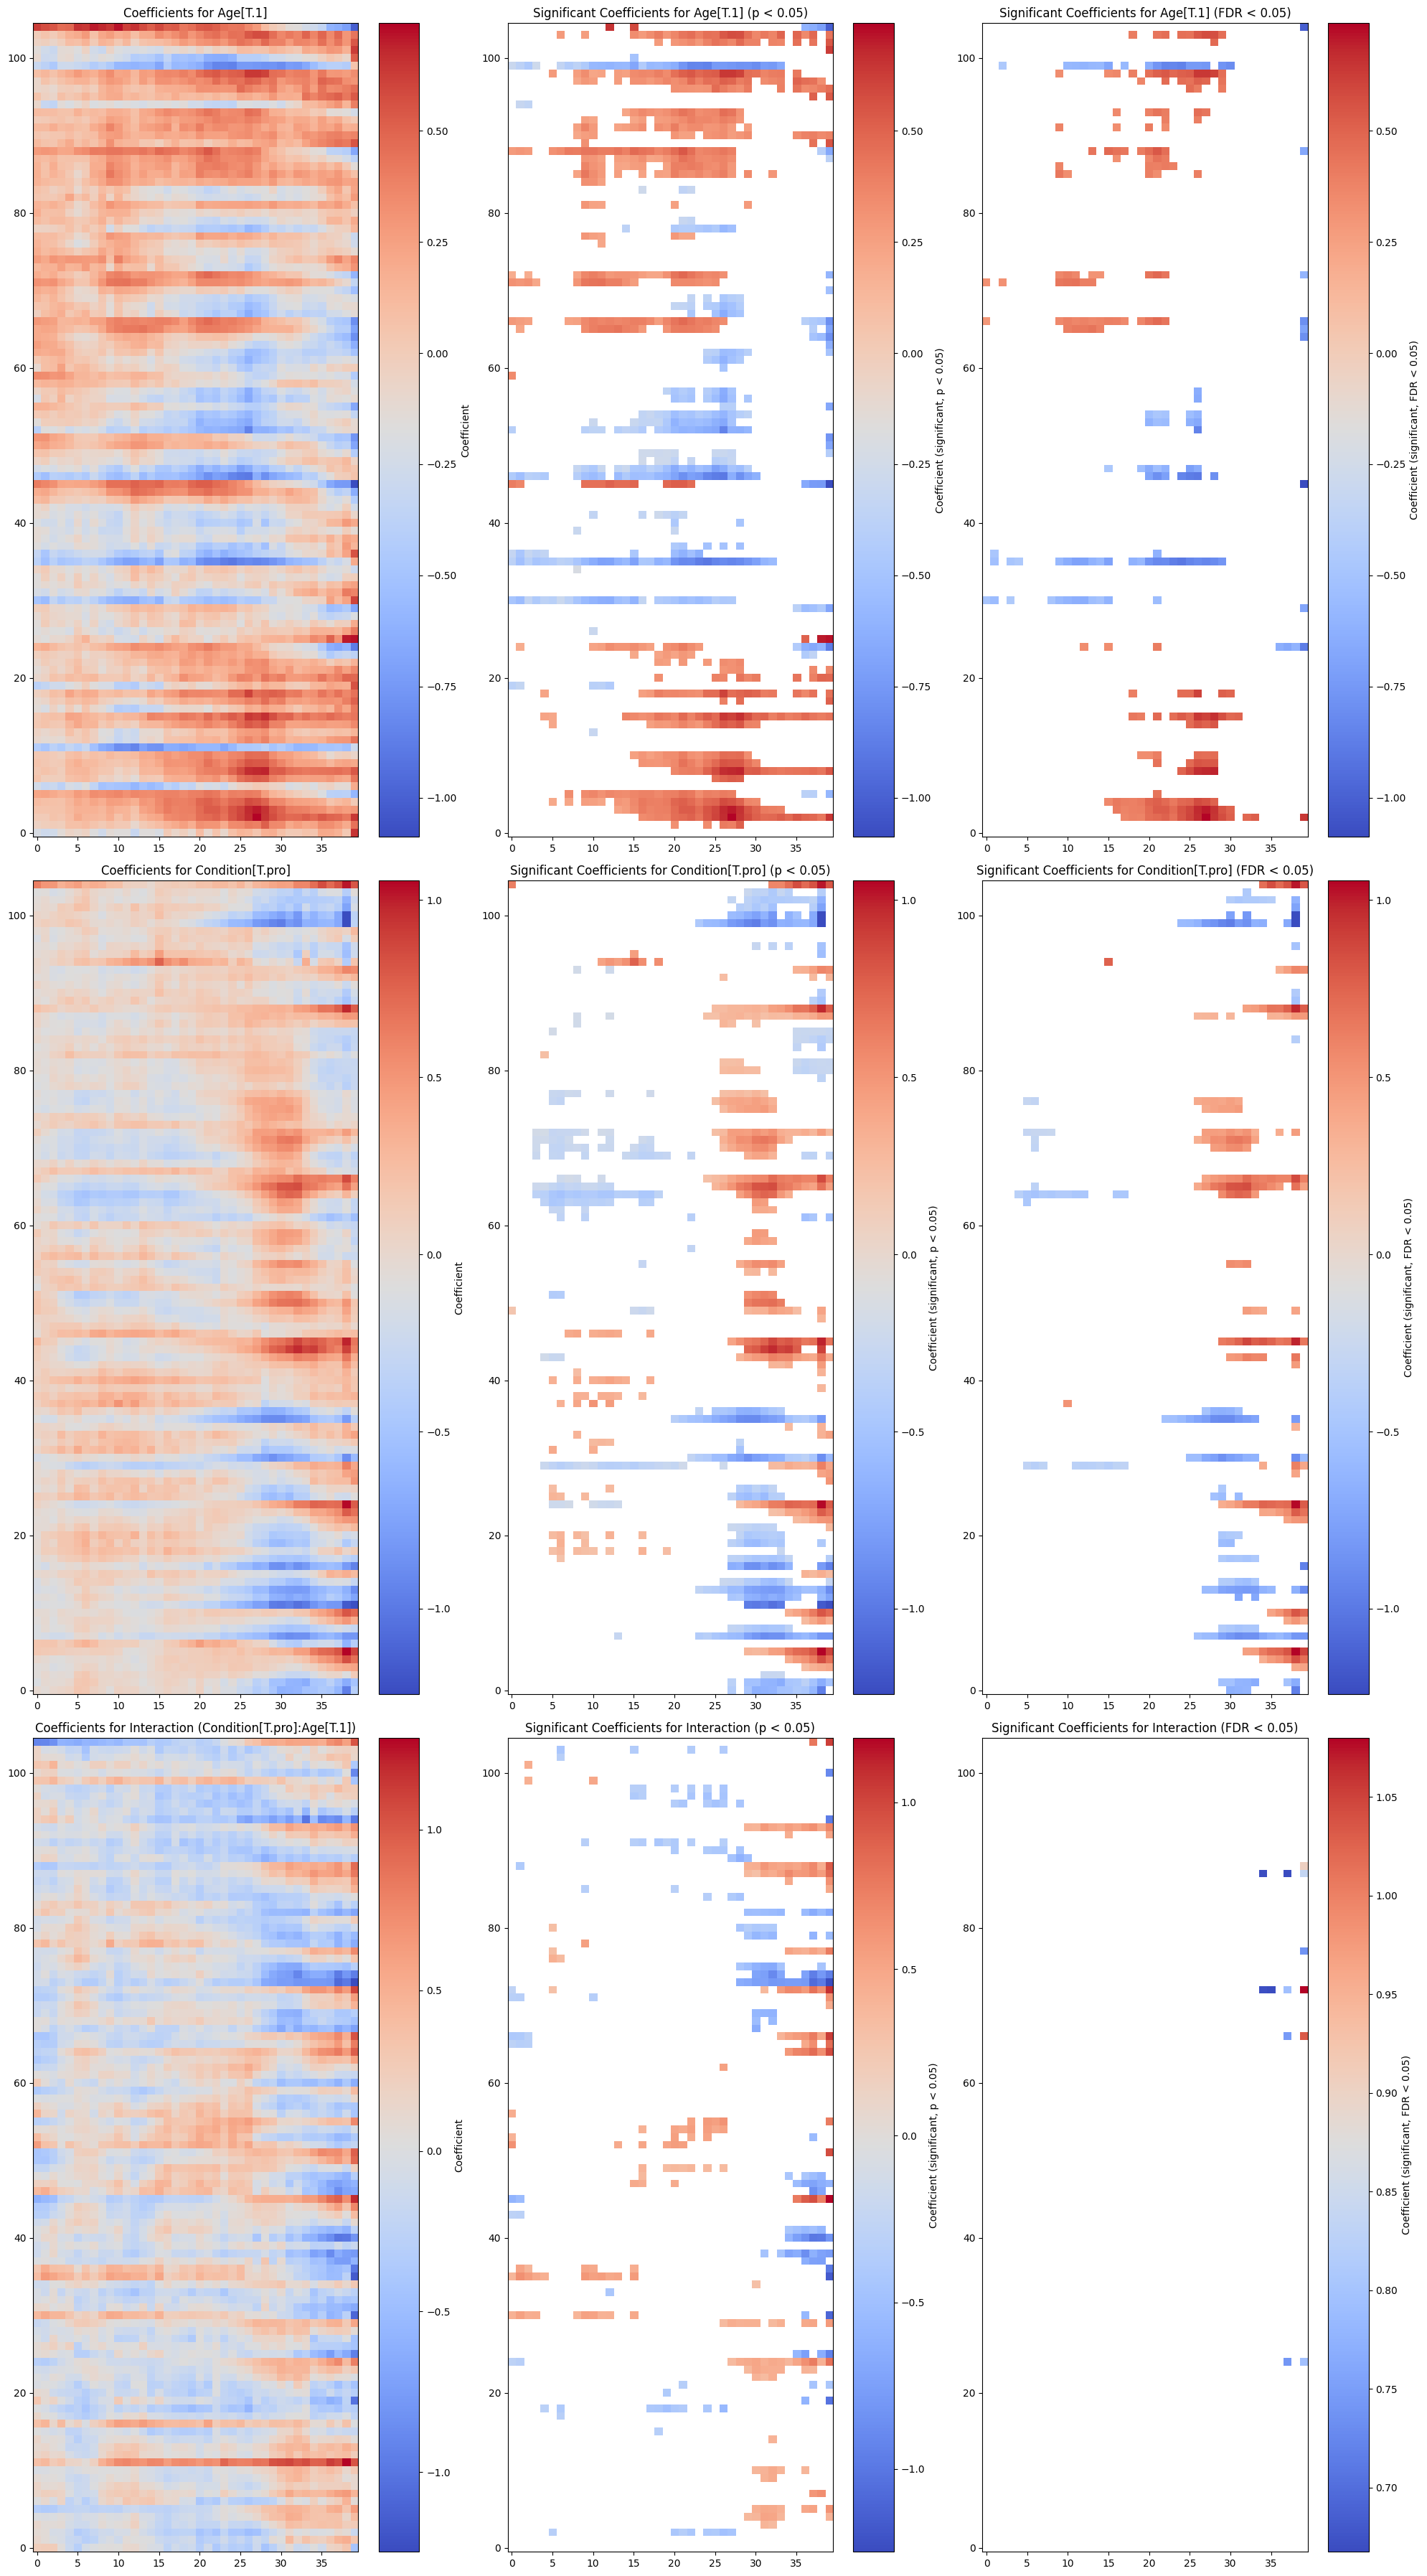

In [27]:
plot_complex_coefficients_with_significance(results)